<a href="https://colab.research.google.com/github/anamika1302/CS-541-NER-SARK_NLP/blob/main/NER_Model3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Training NER MODEL 3 on enitities :**
# **StatusTime,StatusEmploy**


In [ ]:
import json
import os

from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_jsl.json')

with open('spark_jsl.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)
os.environ.update(license_keys)

Saving spark_nlp_for_healthcare_spark_ocr_4699.json to spark_nlp_for_healthcare_spark_ocr_4699.json


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display



     |████████████████████████████████| 212.4 MB 76 kB/s 
     |████████████████████████████████| 142 kB 25.8 MB/s 
     |████████████████████████████████| 198 kB 84.8 MB/s 
     |████████████████████████████████| 95 kB 4.5 MB/s 
     |████████████████████████████████| 66 kB 6.9 MB/s 


In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.1.2 spark-nlp==$PUBLIC_VERSION

# Installing Spark NLP Healthcare
! pip install --upgrade -q spark-nlp-jsl==$JSL_VERSION  --extra-index-url https://pypi.johnsnowlabs.com/$SECRET

# Installing Spark NLP Display Library for visualization
! pip install -q spark-nlp-display

     |████████████████████████████████| 188 kB 4.4 MB/s 


In [ ]:
import sparknlp
import os
from sparknlp.training import CoNLL
spark = sparknlp.start(gpu = True) # for GPU training >> sparknlp.start(gpu = True)

from sparknlp.base import *
from sparknlp.annotator import *

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark



Spark NLP version 3.4.2
Apache Spark version: 3.1.2


In [ ]:
with open('/content/drive/MyDrive/umass_ner/NER_MODEL_3/train_ner_model3.conll') as f:
    train_txt =f.read()

print (train_txt[:500])

-DOCSTART- -X- -X- O

Social NN NN O
History NN NN O
: NN NN O
Tob NN NN O
(-) NNP NNP B-StatusTime
, NN NN O
EtOH NNP NNP B-StatusTime
- NN NN O
a NN NN O
glass NN NN O
of NN NN O
wine NN NN O
1-2x/month NN NN O
, NN NN O
IVDU NN NN O
(-) NNP NNP B-StatusTime
, NN NN O
lives NNP NNP B-StatusTime
with NN NN O
her NN NN O
husband NN NN O
and NN NN O
9yr NN NN O
old NN NN O
daughter NN NN O
, NN NN O
does NNP NNP B-StatusEmploy
not NNP NNP I-StatusEmploy
work NNP NNP I-StatusEmploy
outside NNP NNP


In [ ]:
#Loading training dataset

training_data = CoNLL().readDataset(spark, '/content/drive/MyDrive/umass_ner/NER_MODEL_3/train_ner_model3.conll')

training_data.show(3)



+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|                text|            document|            sentence|               token|                 pos|               label|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Social History : ...|[{document, 0, 15...|[{document, 0, 15...|[{token, 0, 5, So...|[{pos, 0, 5, NN, ...|[{named_entity, 0...|
|SOCIAL HISTORY : ...|[{document, 0, 14...|[{document, 0, 14...|[{token, 0, 5, SO...|[{pos, 0, 5, NN, ...|[{named_entity, 0...|
|Social History : ...|[{document, 0, 12...|[{document, 0, 12...|[{token, 0, 5, So...|[{pos, 0, 5, NN, ...|[{named_entity, 0...|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
training_data.count()

1316

In [ ]:
import pyspark.sql.functions as F

training_data.select(F.explode(F.arrays_zip('token.result', 'pos.result',  'label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("pos"),
        F.expr("cols['2']").alias("ner_label")).limit(100).show()

+----------+---+------------+
|     token|pos|   ner_label|
+----------+---+------------+
|    Social| NN|           O|
|   History| NN|           O|
|         :| NN|           O|
|       Tob| NN|           O|
|       (-)|NNP|B-StatusTime|
|         ,| NN|           O|
|      EtOH|NNP|B-StatusTime|
|         -| NN|           O|
|         a| NN|           O|
|     glass| NN|           O|
|        of| NN|           O|
|      wine| NN|           O|
|1-2x/month| NN|           O|
|         ,| NN|           O|
|      IVDU| NN|           O|
|       (-)|NNP|B-StatusTime|
|         ,| NN|           O|
|     lives|NNP|B-StatusTime|
|      with| NN|           O|
|       her| NN|           O|
+----------+---+------------+
only showing top 20 rows



In [ ]:
training_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)

+--------------+-----+
|ground_truth  |count|
+--------------+-----+
|O             |61723|
|B-StatusTime  |4134 |
|I-StatusTime  |2376 |
|B-StatusEmploy|982  |
|I-StatusEmploy|866  |
+--------------+-----+



In [ ]:
test_data = CoNLL().readDataset(spark, '/content/drive/MyDrive/umass_ner/NER_MODEL_3/testF_ner_model3.conll')

test_data.select(F.explode(F.arrays_zip('token.result','label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("ground_truth")).groupBy('ground_truth').count().orderBy('count', ascending=False).show(100,truncate=False)


+--------------+-----+
|ground_truth  |count|
+--------------+-----+
|O             |5987 |
|B-StatusTime  |474  |
|I-StatusTime  |212  |
|I-StatusEmploy|110  |
|B-StatusEmploy|90   |
+--------------+-----+



In [ ]:
import pyspark.sql.functions as F

test_data.select(F.explode(F.arrays_zip('token.result', 'pos.result',  'label.result')).alias("cols")) \
.select(F.expr("cols['0']").alias("token"),
        F.expr("cols['1']").alias("pos"),
        F.expr("cols['2']").alias("ner_label")).limit(100).show()

+---------+---+------------+
|    token|pos|   ner_label|
+---------+---+------------+
|   SOCIAL| NN|           O|
|  HISTORY| NN|           O|
|        :| NN|           O|
|    Lives|NNP|B-StatusTime|
|     with| NN|           O|
|      his| NN|           O|
|   caring| NN|           O|
|      and| NN|           O|
|  devoted| NN|           O|
|  parents| NN|           O|
|       at| NN|           O|
|     home| NN|           O|
|        .| NN|           O|
|   Enjoys| NN|           O|
|   movies| NN|           O|
|      and| NN|           O|
|computers| NN|           O|
|        .| NN|           O|
|       No|NNP|B-StatusTime|
|  history|NNP|I-StatusTime|
+---------+---+------------+
only showing top 20 rows



In [ ]:
bert_embedding = BertEmbeddings.pretrained('bert_base_cased', 'en')\
   .setInputCols(["sentence",'token'])\
   .setOutputCol("bert_embeddings")\
   .setCaseSensitive(True)

bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[OK!]


In [ ]:
!rm -r /content/drive/MyDrive/umass_ner/NER_MODEL_3/testF_data_ner_model3_bert_embedding.parquet

In [ ]:
bert_embedding.transform(test_data).write.parquet('/content/drive/MyDrive/umass_ner/NER_MODEL_3/testF_data_ner_model3_bert_embedding.parquet')

In [ ]:
# !rm -r /content/drive/MyDrive/umass_ner/NER_MODEL_1/test_data_bert_embedding.parquet

In [ ]:
# !mkdir /root/ner_logs_model1

In [ ]:
# !rm -r /content/ner_dl_logs_model3

In [ ]:
nerTagger = NerDLApproach()\
      .setInputCols(["sentence", "token", "bert_embeddings"])\
      .setLabelColumn("label")\
      .setOutputCol("ner")\
      .setMaxEpochs(15)\
      .setLr(0.0002)\
      .setBatchSize(16)\
      .setRandomSeed(0)\
      .setVerbose(1)\
      .setEvaluationLogExtended(True) \
      .setEnableOutputLogs(True)\
      .setIncludeConfidence(True)\
      .setUseBestModel(True)\
      .setTestDataset('/content/drive/MyDrive/umass_ner/NER_MODEL_3/testF_data_ner_model3_bert_embedding.parquet')\
      .setOutputLogsPath('./ner_dl_logs_model3')# if not set, logs will be written to ~/annotator_logs
 #    .setGraphFolder('graphs') >> put your graph file (pb) under this folder if you are using a custom graph generated thru 4.1 NerDL-Graph.ipynb notebook
 #    .setEnableMemoryOptimizer() >> if you have a limited memory and a large conll file, you can set this True to train batch by batch 
    
# do hyperparameter by tuning the params above (max epoch, LR, dropout etc.) to get better results
ner_pipeline = Pipeline(stages=[
      bert_embedding,
      nerTagger
 ])



In [ ]:
ner_model = ner_pipeline.fit(training_data)

In [ ]:
!cd /content/ner_dl_logs_model3 && ls -lt

total 24
-rw-r--r-- 1 root root 9119 Apr 28 03:59 NerDLApproach_4702adc74552.log
-rw-r--r-- 1 root root 8927 Apr 28 03:59 NerDLApproach_51ea32b2bd75.log


In [ ]:
!cat /content/ner_dl_logs_model3/NerDLApproach_4702adc74552.log

Name of the selected graph: ner-dl/blstm_10_768_128_120.pb
Training started - total epochs: 15 - lr: 2.0E-4 - batch size: 16 - labels: 5 - chars: 89 - training examples: 1316


Epoch 1/15 started, lr: 2.0E-4, dataset size: 1316


Epoch 1/15 - 23.52s - loss: 2173.3035 - batches: 85
Quality on test dataset: 
time to finish evaluation: 2.13s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-StatusEmploy	 0	 0	 90	 0.0	 0.0	 0.0
B-StatusTime	 214	 38	 258	 0.8492063	 0.45338982	 0.59116024
I-StatusTime	 0	 0	 209	 0.0	 0.0	 0.0
I-StatusEmploy	 0	 0	 110	 0.0	 0.0	 0.0
tp: 214 fp: 38 fn: 667 labels: 4
Macro-average	 prec: 0.21230158, rec: 0.113347456, f1: 0.14779006
Micro-average	 prec: 0.8492063, rec: 0.2429058, f1: 0.37775818


Epoch 2/15 started, lr: 1.9900496E-4, dataset size: 1316


Epoch 2/15 - 23.73s - loss: 1438.5688 - batches: 85
Quality on test dataset: 
time to finish evaluation: 1.59s
label	 tp	 fp	 fn	 prec	 rec	 f1
B-StatusEmploy	 24	 8	 66	 0.75	 0.26666668	 0.39344266
B-StatusTime	 336	 63

In [ ]:
pred_df = ner_model.stages[1].transform(bert_embedding.transform(test_data))
# pred_df = ner_model.stages[1].transform(test_data)

In [ ]:
import pyspark.sql.functions as F

pred_df.select(F.explode(F.arrays_zip(pred_df.token.result,
                                          pred_df.label.result,
                                          pred_df.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).toPandas()

,token,ground_truth,prediction
0,SOCIAL,O,O
1,HISTORY,O,O
2,:,O,O
3,Lives,B-StatusTime,B-StatusTime
4,with,O,O
...,...,...,...
6868,father,O,O
6869,of,O,O
6870,one,O,O
6871,son,O,O


In [ ]:
import pyspark.sql.functions as F

pred_df.select(F.explode(F.arrays_zip(pred_df.token.result,
                                          pred_df.label.result,
                                          pred_df.ner.result)).alias("cols")) \
                              .select(F.expr("cols['0']").alias("token"),
                                      F.expr("cols['1']").alias("ground_truth"),
                                      F.expr("cols['2']").alias("prediction")).show(truncate=False)



+---------+------------+------------+
|token    |ground_truth|prediction  |
+---------+------------+------------+
|SOCIAL   |O           |O           |
|HISTORY  |O           |O           |
|:        |O           |O           |
|Lives    |B-StatusTime|B-StatusTime|
|with     |O           |O           |
|his      |O           |O           |
|caring   |O           |O           |
|and      |O           |O           |
|devoted  |O           |O           |
|parents  |O           |O           |
|at       |O           |O           |
|home     |O           |O           |
|.        |O           |O           |
|Enjoys   |O           |O           |
|movies   |O           |O           |
|and      |O           |O           |
|computers|O           |O           |
|.        |O           |O           |
|No       |B-StatusTime|B-StatusTime|
|history  |I-StatusTime|I-StatusTime|
+---------+------------+------------+
only showing top 20 rows



In [ ]:
from sklearn.metrics import classification_report

preds_df_analysis = pred_df.select(F.explode(F.arrays_zip(pred_df.token.result,
                                                     pred_df.label.result,
                                                     pred_df.ner.result)).alias("cols")) \
                      .select(F.expr("cols['0']").alias("token"),
                              F.expr("cols['1']").alias("ground_truth"),
                              F.expr("cols['2']").alias("prediction")).toPandas()
preds_df_analysis["prediction"].fillna( method ='ffill', inplace = True)
print (classification_report(preds_df_analysis['ground_truth'], preds_df_analysis['prediction']))


                precision    recall  f1-score   support

B-StatusEmploy       0.83      0.88      0.85        90
  B-StatusTime       0.81      0.86      0.83       474
I-StatusEmploy       0.86      0.67      0.76       110
  I-StatusTime       0.64      0.29      0.40       212
             O       0.96      0.98      0.97      5987

      accuracy                           0.94      6873
     macro avg       0.82      0.74      0.76      6873
  weighted avg       0.94      0.94      0.94      6873



In [ ]:

# idx = preds_df_analysis.loc[preds_df_analysis['ground_truth'].isnull(),'ground_truth'].index


# preds_df_analysis.loc[idx]

In [ ]:
ner_model.stages[1].write().overwrite().save('/content/drive/MyDrive/umass_ner/model_ner_dl_3')

In [ ]:
!wget  -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/conll_eval.py

import conll_eval

metrics = conll_eval.evaluate(preds_df_analysis['ground_truth'].values, preds_df_analysis['prediction'].values)


import pandas as pd
pd.DataFrame(metrics[1], columns=['entity','precision','recall','f1','support'])



processed 6873 tokens with 564 phrases; found: 606 phrases; correct: 417.
accuracy:  70.09%; (non-O)
accuracy:  94.15%; precision:  68.81%; recall:  73.94%; FB1:  71.28
     StatusEmploy: precision:  64.71%; recall:  73.33%; FB1:  68.75  102
       StatusTime: precision:  69.64%; recall:  74.05%; FB1:  71.78  504


,entity,precision,recall,f1,support
0,StatusEmploy,64.705882,73.333333,68.750000,102
1,StatusTime,69.642857,74.050633,71.779141,504


In [ ]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/utils/ner_log_parser.py


In [ ]:
import ner_log_parser

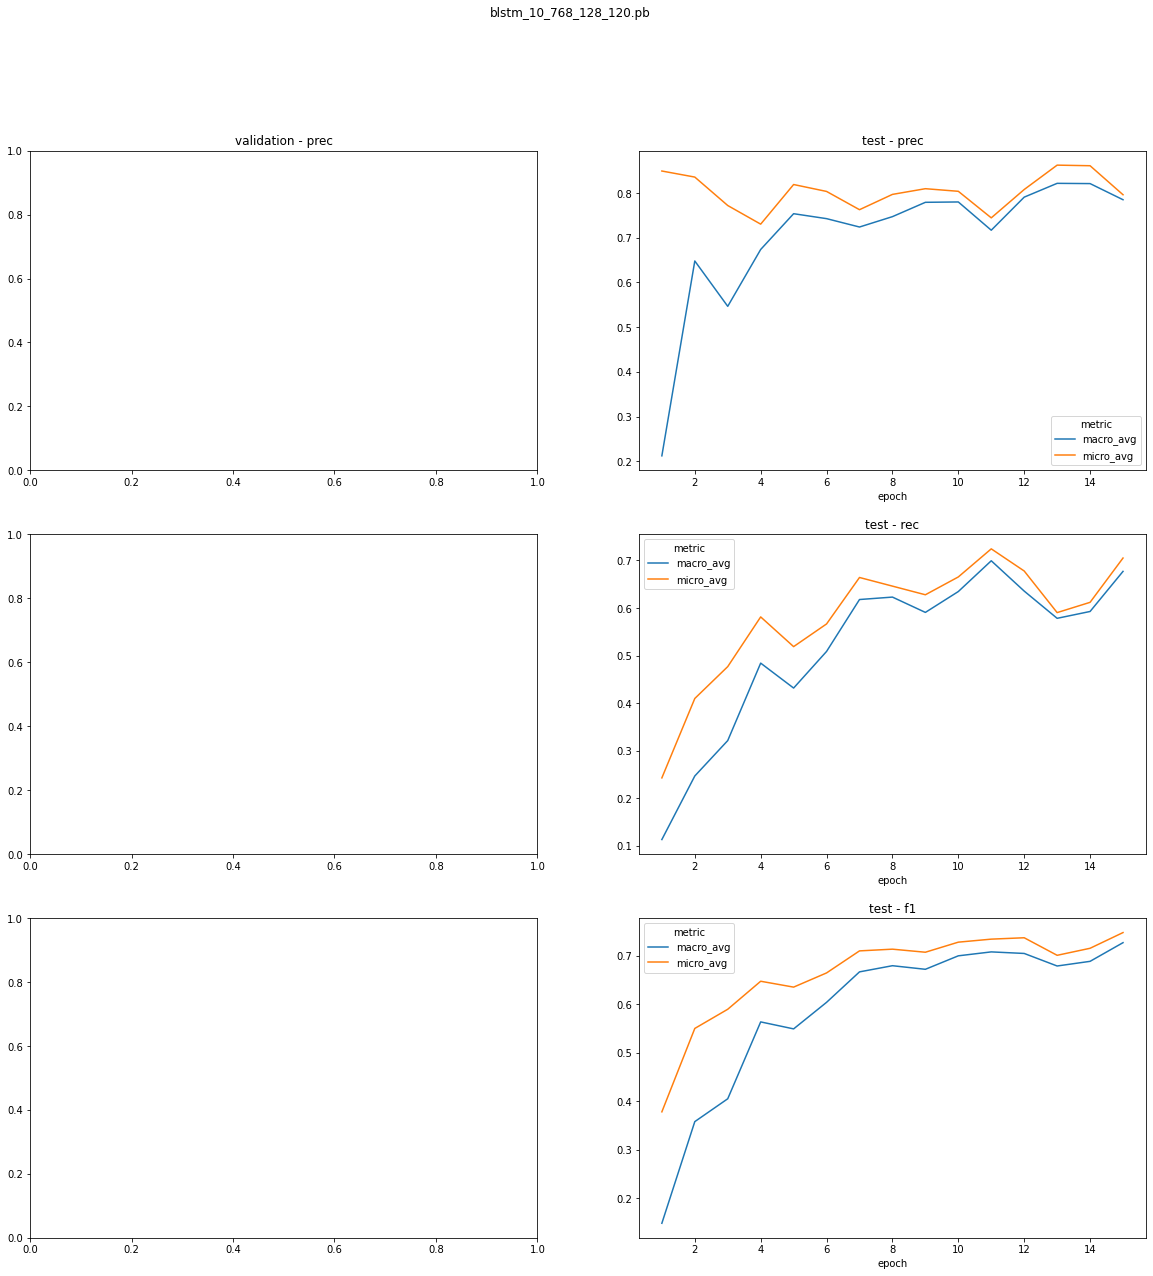

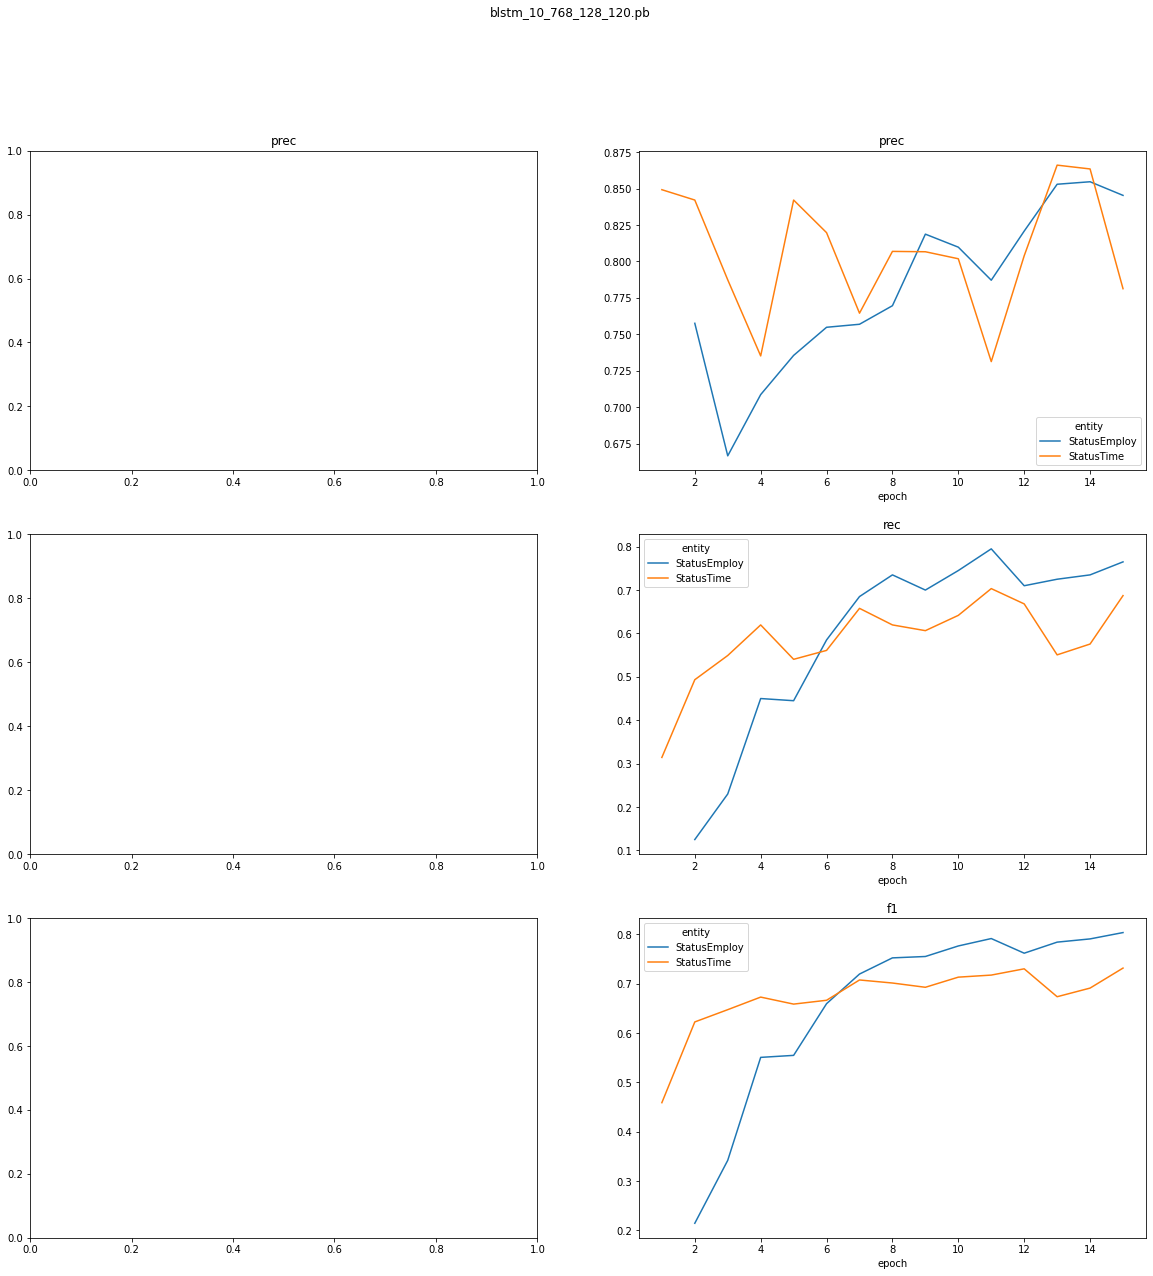

In [ ]:
ner_log_parser.get_charts('/content/ner_dl_logs_model3/NerDLApproach_4702adc74552.log')

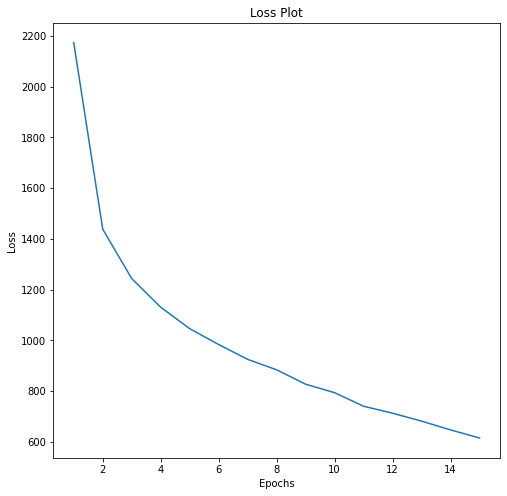

In [ ]:
ner_log_parser.loss_plot('/content/ner_dl_logs_model3/NerDLApproach_4702adc74552.log')

In [ ]:


document = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

sentence = SentenceDetector()\
        .setInputCols(['document'])\
        .setOutputCol('sentence')

token = Tokenizer()\
        .setInputCols(['sentence'])\
        .setOutputCol('token')

bert_embedding = BertEmbeddings.pretrained('bert_base_cased', 'en')\
   .setInputCols(["sentence",'token'])\
   .setOutputCol("bert_embeddings")\
   .setCaseSensitive(True)
  
# load trained model
loaded_ner_model = NerDLModel.load("/content/drive/MyDrive/umass_ner/model_ner_dl_3")\
        .setInputCols(["sentence", "token", "bert_embeddings"])\
        .setOutputCol("ner")

converter = NerConverter()\
        .setInputCols(["document", "token", "ner"])\
        .setOutputCol("ner_span")

ner_prediction_pipeline = Pipeline(stages = [
        document,
        sentence,
        token,
        bert_embedding,
        loaded_ner_model,
        converter
])



bert_base_cased download started this may take some time.
Approximate size to download 389.1 MB
[OK!]


In [ ]:

empty_data = spark.createDataFrame([['']]).toDF("text")

prediction_model = ner_prediction_pipeline.fit(empty_data)



In [ ]:
pred_df= prediction_model.transform(test_data)

In [ ]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(prediction_model)


In [ ]:
# file = 415
text = """SOCIAL HISTORY:  The patient quit smoking cigarettes 15 years
ago.  She has a history of heavy alcohol consumption in the
past, but none for the past 13 years.  She is a former
employee of the state lottery."""

In [ ]:
import pandas as pd

result = light_model.fullAnnotate(text)

ner_df= pd.DataFrame([(int(x.metadata['sentence']), x.result, x.begin, x.end, y.result) for x,y in zip(result[0]["token"], result[0]["ner"])], 
                      columns=['sent_id','token','start','end','ner'])
ner_df

,sent_id,token,start,end,ner
0,0,SOCIAL,0,5,O
1,0,HISTORY,7,13,O
2,0,:,14,14,O
3,0,The,17,19,O
4,0,patient,21,27,O
5,0,quit,29,32,B-StatusTime
6,0,smoking,34,40,O
7,0,cigarettes,42,51,O
8,0,15,53,54,O
9,0,years,56,60,O


In [ ]:
from sparknlp_display import NerVisualizer

visualiser = NerVisualizer()

visualiser.display(result[0], label_col='ner_span', document_col='document', save_path="display_result.html")